In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error

In [12]:
gold_data=pd.read_csv('gold_price_data_2008_2024.csv')
gold_data.head(10)

,Date,Gold Price
0,31-08-2008,1190
1,30-08-2008,1188
2,29-08-2008,1186
3,30-09-2008,1350
4,29-09-2008,1317
5,27-09-2008,1315
6,26-09-2008,1301
7,25-09-2008,1312
8,24-09-2008,1299
9,23-09-2008,1310


In [13]:
gold_data.shape

(5667, 2)

In [14]:
gold_data.isna().sum()

Date          0
Gold Price    0
dtype: int64

In [15]:
gold_data.dtypes

Date          object
Gold Price     int64
dtype: object

In [16]:
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%d-%m-%Y')
gold_data['Dates'] = gold_data['Date'].dt.day
gold_data['Month'] = gold_data['Date'].dt.month
gold_data['Year'] = gold_data['Date'].dt.year
print(gold_data)

           Date  Gold Price  Dates  Month  Year
0    2008-08-31        1190     31      8  2008
1    2008-08-30        1188     30      8  2008
2    2008-08-29        1186     29      8  2008
3    2008-09-30        1350     30      9  2008
4    2008-09-29        1317     29      9  2008
...         ...         ...    ...    ...   ...
5662 2024-05-03        7039      3      5  2024
5663 2024-05-02        7069      2      5  2024
5664 2024-05-01        7047      1      5  2024
5665 2024-06-02        7205      2      6  2024
5666 2024-06-01        7205      1      6  2024

[5667 rows x 5 columns]


In [17]:
x = gold_data[['Year','Month','Dates']]
y = gold_data['Gold Price']

In [18]:
x_test,x_train,y_test,y_train= train_test_split(x,y,test_size=0.2, random_state=42)

In [22]:
xgb_reg_model=xgb.XGBRegressor(objective= 'reg:squarederror')


param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

grid_search=GridSearchCV(estimator=xgb_reg_model,param_grid=param_grid,cv=3,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)

grid_search.fit(x_train,y_train)

best_params=grid_search.best_params_
best_score=grid_search.best_score_

print(f"Best parameters:{best_params}")
print(f"Best Score:{best_score}")

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters:{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best Score:-5339.782724911875


In [24]:
best_xg_reg = grid_search.best_estimator_
preds = best_xg_reg.predict(x_test)

mse = mean_squared_error(y_test, preds)
print(f"Mean Squared Error: {mse}")

# Calculate the Accuracy
accuracy = 1 - (mse / y_test.var())
print("Accuracy:", accuracy)

Mean Squared Error: 13777.572242222272
Accuracy: 0.9924981816752242


In [53]:
def predict_gold_price(date_str, model):
    date = pd.to_datetime(date_str)
    year = date.year
    month = date.month
    day = date.day
    input_features = pd.DataFrame({'Year': [year], 'Month': [month], 'Dates': [day]})
    predicted_price = model.predict(input_features)
    return predicted_price[0]

date_to_predict = '06-06-2012'
predicted_price = predict_gold_price(date_to_predict, best_xg_reg)
print(f"Predicted Gold Price for {date_to_predict}: {predicted_price}")
     

Predicted Gold Price for 06-06-2012: 2967.119140625


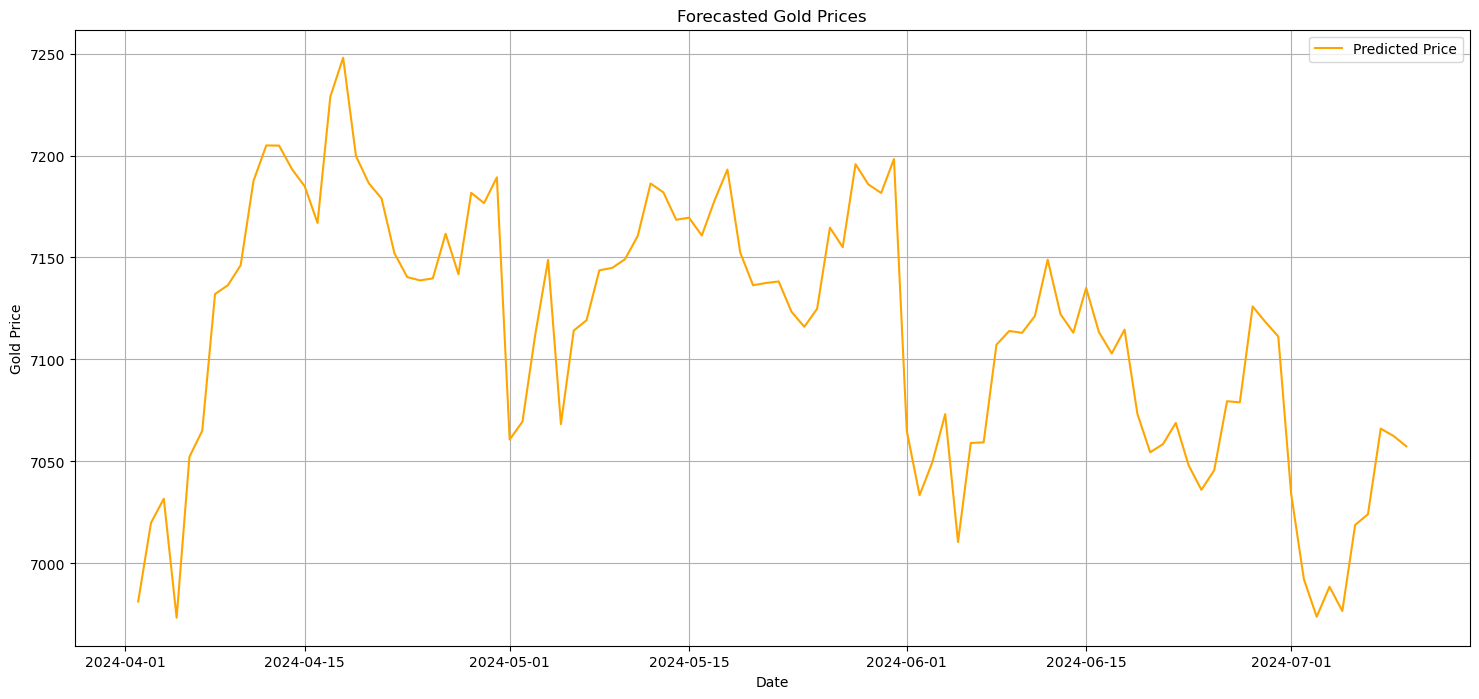

In [52]:
import matplotlib.pyplot as plt


def predict_gold_prices(model, start_date, steps):
    # Initialize an empty DataFrame to store the predicted prices
    forecast = pd.DataFrame(columns=['Date', 'Predicted_Price'])

    # Convert start_date to datetime
    start_date = pd.to_datetime(start_date)

    # Loop through the number of steps and make predictions for each step
    for i in range(1, steps+1):
        # Calculate the date for the current step
        current_date = start_date + pd.DateOffset(days=i)

        # Extract features from the current date
        year = current_date.year
        month = current_date.month
        day = current_date.day

        # Create input features DataFrame for prediction
        input_features = pd.DataFrame({'Year': [year], 'Month': [month], 'Dates': [day]})

        # Predict the gold price for the current date
        predicted_price = model.predict(input_features)

        # Append the predicted price to the forecast DataFrame
        forecast = pd.concat([forecast, pd.DataFrame({'Date': [current_date], 'Predicted_Price': predicted_price})], ignore_index=True)

    return forecast

start_date = '2024-04-01'

forecast_steps = 100

forecast = predict_gold_prices(best_xg_reg, start_date, forecast_steps)

plt.figure(figsize=(18, 8))
plt.plot(forecast['Date'], forecast['Predicted_Price'], label='Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Forecasted Gold Prices')
plt.grid(True)
plt.legend()
plt.show()


In [47]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, preds)
print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.9924965263755057
